# Bibliotecas utilizadas

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Tarea 1

## Lectura de la imagen de disco para realizar pruebas

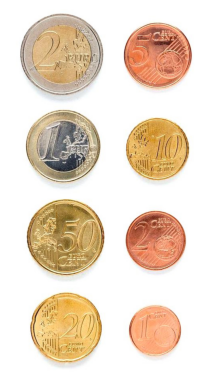

In [2]:
image = cv2.imread("imgs/Monedas.jpg", cv2.IMREAD_COLOR_RGB)

plt.axis('off')
plt.imshow(image, cmap='gray')

## Pruebas de umbralización y Canny

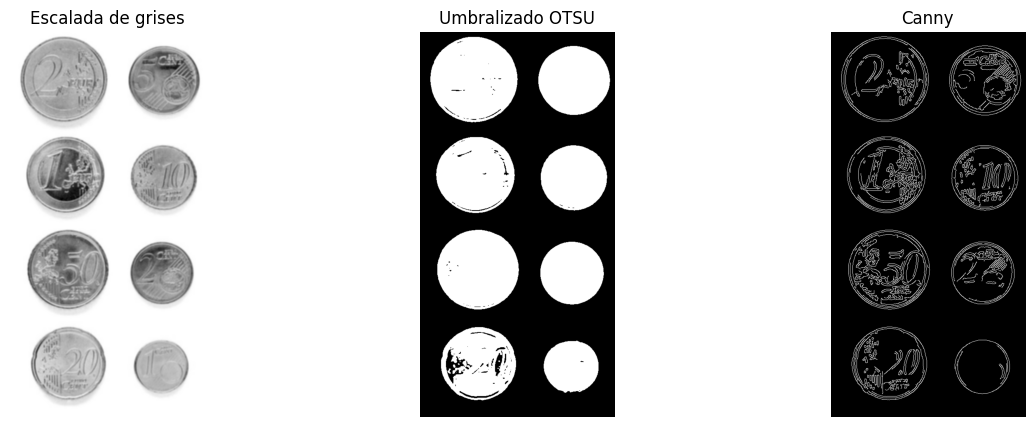

In [4]:
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image_gray = cv2.GaussianBlur(image_gray, (5, 5), 2)

canny = cv2.Canny(image_gray, 50, 125)

_, threshold_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Escalada de grises')
plt.imshow(image_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Umbralizado OTSU')
plt.imshow(threshold_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Canny')
plt.imshow(canny, cmap='gray')
plt.axis('off')

plt.savefig('imgs/preproceso_monedas.jpg')

## Para contornos

### Modelo para representar el dinero

In [7]:
from dataclasses import dataclass

@dataclass
class Coin:
    value: int
    diameter: float
    
    def __add__(self, other):
        if isinstance(other, Coin):
            return Money(self.value + other.value)
        elif isinstance(other, Money):
            return Money(self.value + other.value)
        return NotImplemented

    def __radd__(self, other):
        if other == 0:
            return Money(self.value)
        elif isinstance(other, Money):
            return Money(self.value + other.value)
        return NotImplemented
            

@dataclass
class Money:
    value: int

    def amount(self):
        return self.value / 100

### Clase desarrollada para el conteo

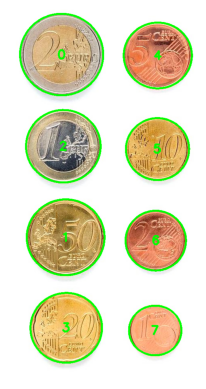

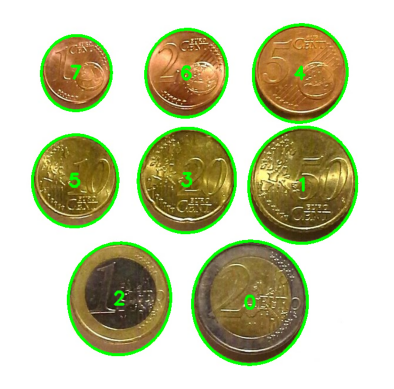

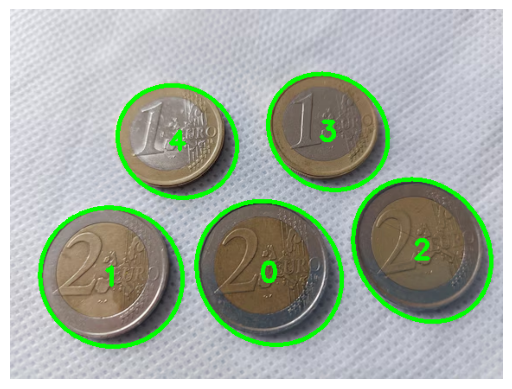

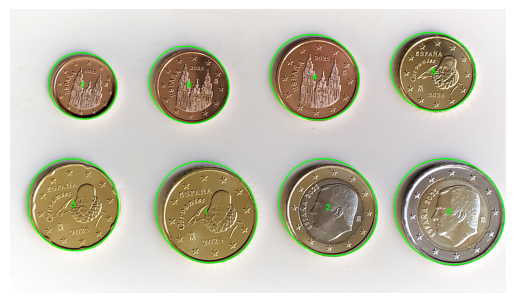

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


3.88


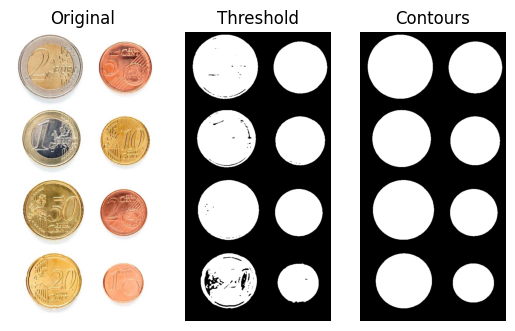

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


3.88


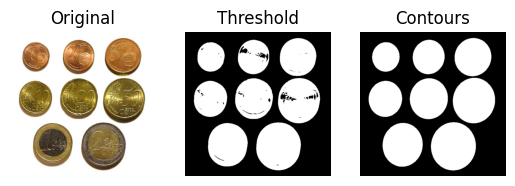

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


8.0


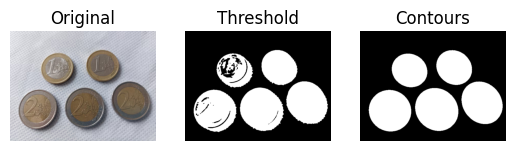

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


3.88


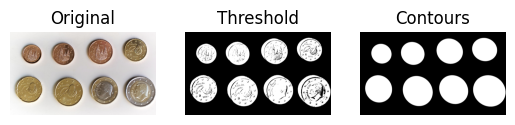

In [8]:
class MoneyCounter:
    coins_d = {
        '200': 25.75,
        '100': 23.25,
        '50': 24.25,
        '20': 22.25,
        '10': 19.75,
        '5': 21.25,
        '2': 18.75,
        '1': 16.25
    }

    coins_invert = {v: int(k) for k, v in coins_d.items()}

    def __init__(self, image):
        self.image = cv2.imread(image)
        self.thresh_image, self.canny = self.__preproccess_image()
        self.ellipses = self.__find_circular_contours(self.thresh_image)
        self.selected_coin = None
        self.selected_index = None
        self.PIXEL_MM_RATIO = None

    def show_detection_and_pick_coin(self, coin):
        self.selected_coin = coin
        drawed = self.__draw_found__ellipses_information()
        plt.imshow(drawed, cmap='gray')
        plt.axis('off')
        plt.show()
        self.selected_index = input(f"Selecciona el índice de la moneda con valor {coin}")
        return drawed, self.selected_index
        
    def __preproccess_image(self):
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 2)
        _, thresh_image = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        canny = cv2.Canny(blur, 50, 115)
        return thresh_image, canny
    
    def __calculate_circularity(self, contour):
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if perimeter == 0:
            return False
        
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        return circularity >= 0.6 and area > 50

        
    def __find_circular_contours(self, image):
        contours, _ = cv2.findContours(
            image,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        contours = sorted(
            [c for c in contours if self.__calculate_circularity(c)],
            key=lambda c: cv2.contourArea(c), reverse=True
        )
        contours_ellipses = {}

        for i, c in enumerate(contours):
            ellipse = cv2.fitEllipse(c)
            contours_ellipses[i] = {
                'ellipse': ellipse,
                'center': ellipse[0],
                'width': min(ellipse[1]),
                'angle': ellipse[2]
            }
        
        return contours_ellipses

    def __draw_found__ellipses_information(self):
        image_copy = self.image.copy()
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

        for i, c in enumerate(self.ellipses.values()):
            (x, y) = c['center']
            cv2.ellipse(image_copy, c['ellipse'], (0, 255, 0), 3)
            cv2.putText(
                image_copy,
                f"{i}",
                (int(x) - 10, int(y) + 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                3
            )

        return image_copy
    
    def __draw_found_ellipses_information_upon_empty_canvas(self):
        canvas = np.zeros(self.image.shape)

        if len(self.ellipses) != 0:
            for e in self.ellipses.values():
                cv2.ellipse(canvas, e['ellipse'], (255, 255, 255), -1)

        return canvas
        
    
    def do_the_math(self, debug):
        if len(self.ellipses) == 0:
            print('No se han encontrado figuras suficientes para hacer las mates.')
            return

        self.PIXEL_MM_RATIO = self.ellipses[int(self.selected_index)]['width'] / MoneyCounter.coins_d['100']

        current = []

        for c in self.ellipses.values():
            r = c['width']
            d = r / self.PIXEL_MM_RATIO
            k = min(MoneyCounter.coins_invert, key=lambda k: abs(k - d))
            current.append(Coin(MoneyCounter.coins_invert[k], k))

        debugged = {}

        if debug:
            debugged['original'] = cv2.cvtColor(self.image.copy(), cv2.COLOR_BGR2RGB)
            debugged['threshold'] = self.thresh_image
            debugged['contours'] = self.__draw_found_ellipses_information_upon_empty_canvas()
            debugged['money'] = sum(current).amount()

        return sum(current), current, debugged
        
if __name__ == '__main__':
    monedas = MoneyCounter('imgs/Monedas.jpg')
    shadow = MoneyCounter('imgs/coins_with_shadow.jpg')
    v2 = MoneyCounter('imgs/coins_v2.jpg')
    v3 = MoneyCounter('imgs/coins_v3.jpg')

    result_monedas, selected_monedas = monedas.show_detection_and_pick_coin(1)
    result_shadow, selected_shadow = shadow.show_detection_and_pick_coin(1)
    result_v2, selected_v2 = v2.show_detection_and_pick_coin(1)
    result_v3, selected_v3 = v3.show_detection_and_pick_coin(1)

    _, _, d_monedas = monedas.do_the_math(True)
    _, _, d_shadow = shadow.do_the_math(True)
    _, _, d_v2 = v2.do_the_math(True)
    _, _, d_v3 = v3.do_the_math(True)

    debugs = [
        d_monedas, d_shadow, d_v2, d_v3
    ]

    for idx, d in enumerate(debugs):
        plt.figure()
        for sub, (title, image) in enumerate(d.items()):
            if title == 'money':
                continue

            plt.subplot(1, 3, sub + 1)
            plt.axis('off')
            plt.title(title.capitalize())
            plt.imshow(image, cmap='gray')

        print(d['money'])
        plt.savefig(f"imgs/conteo_{idx}.jpg")
        plt.show()
    


## Tarea 2:

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas basadas en características geométricas y/o de apariencia, a partir de las imágenes completas de las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello sobre las anotaciones de la imagen de test *MPs_test.png*. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.
TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.


# Características -> Traducción a OPENCV

Área en píxeles
area = cv2.contourArea(contour)
se consideran microplásticos cuando miden menos de 5mm


Perímetro en píxeles
Puede suavizarse el contorno (por ejemplo con un cv2.approxPolyDP) si el ruido es alto.
pixel = cv2.arcLength(contour, closed=True)


Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
Compacidad = (P^2)/A -> Inverso a la circularidad
Compacidad grande -> Contorno rugoso
Compacidad aproximada a 12.57(≈ 4 × π) -> Circular

Circularidad = (4πA)/(P^2)
 Circularidad = 1 / (Compacidad/4π)


Relación del área de la partícula con la del contenedor
ratio_Area = Area_particula/Area_contenedor
x, y, w, h = cv2.boundingRect(contour) # bounding box (rectángulo mínimo que contiene la partícula).
A_box = w * h
A_ratio = A / A_box


Relación del ancho y el alto del contenedor
E_Ratio = a/b (ejes de la elipse)
ellipse = cv2.fitEllipse(contour)
(xc, yc), (major_axis, ma), angle = ellipse
E_ratio = major_axis/ ma



Relación entre los ejes de la elipse ajustada



Definido el centroide, relación entre las distancias menor y mayor al contorno



# Función para extraer las zonas de la imagen delimitada por un contorno

In [3]:
import cv2
import numpy as np

def extract_contour_region(image, contour):
    """
    Extrae el área de la imagen que corresponde al contorno dado.

    Args:
        image (numpy.ndarray): Imagen original (BGR o gris).
        contour (numpy.ndarray): Contorno (array de coordenadas) obtenido de cv2.findContours.

    Returns:
        region (numpy.ndarray): Imagen recortada con solo los píxeles dentro del contorno.
                                 Los píxeles fuera del contorno son negros (0).
    """

    # Crear máscara negra del tamaño de la imagen
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Dibujar el contorno relleno en la máscara
    cv2.drawContours(mask, [contour], -1, color=255, thickness=-1)

    # Aplicar máscara a la imagen
    region = cv2.bitwise_and(image, image, mask=mask)

    return region


## Función para extraer características geométricas

In [51]:
def geometric_features(contour, region):

    if len(contour) < 3:
        return {k: 0 for k in [
            "Area", "Perimeter", "Compacidad", "Circularity",
            "Area_ratio", "Aspect_ratio", "E_ratio", "D_ratio"
        ]}

    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0 or area == 0:
        return {k: 0 for k in [
            "Area", "Perimeter", "Compacidad", "Circularity",
            "Area_ratio", "Aspect_ratio", "E_ratio", "D_ratio"
        ]}

    compacity = (perimeter**2) / area # if perimeter > 0 or area > 0 else 0
    circularity = (4*np.pi*area) / (perimeter**2) # if perimeter > 0 or area > 0 else 0

    _, _, w, h = cv2.boundingRect(contour)
    box_area = w * h
    ratio_area = area / box_area if box_area > 0 else 0
    aspect_ratio = w / h if h > 0 else 0

    """
    E_ratio < 1.2 and D_ratio > 0.9 → circular.
    E_ratio > 2.5 or D_ratio < 0.5 → alargada.
    ratio_area < 0.6 and C > 20 → forma irregular.
    """ 
    e_ratio = 0
    if len(contour) >= 5:
        (_, _), (major_axis, minor_axis), _ = cv2.fitEllipse(contour)
        e_ratio = major_axis / minor_axis if minor_axis > 0 else 0

    d_ratio = 0
    M = cv2.moments(contour)
    if M["m00"] != 0:
        xc = M["m10"]/M["m00"]
        yc = M["m01"]/M["m00"]
        dist = np.sqrt((contour[:,0,0]-xc)**2 + (contour[:,0,1]-yc)**2)
        d_ratio = dist.min() / dist.max() if dist.max() > 0 else 0

    threshold = 50  # cualquier valor menor a 50 se considera negro en B,G,R

    # Extraer solo los píxeles dentro del contorno (no negros por fuera del mask)
    pixels_in_contour = region[ np.any(region != 0, axis=2) ]  # BGR != 0

    fraccion_oscura = np.mean(np.all(pixels_in_contour < threshold, axis=1))

    # Si la mayoría del contorno es oscuro (ajusta 0.5 si quieres otro criterio)
    is_black = int(fraccion_oscura > 0.7)

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    mask = np.zeros(region.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=-1)  # rellena el contorno en la máscara
    pixels_in_contour = region[mask == 255]
    gray_pixels = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)[mask == 255]
    mean_intensity = np.mean(gray_pixels) if gray_pixels.size else 0
    std_intensity  = np.std(gray_pixels)  if gray_pixels.size else 0

    # return area, perimeter, compacity, circularity, ratio_area, AR, E_ratio, D_ratio
    return {
        "Area": area,
        "Perimeter": perimeter,
        "Compacidad": compacity,
        "Circularity": circularity,
        "Area_ratio": ratio_area,
        "Aspect_ratio": aspect_ratio, 
        "E_ratio": e_ratio, 
        "D_ratio": d_ratio,
        "Intensity": mean_intensity,
        "Std": std_intensity,
        "test": mean_intensity * circularity,
        "Solidity": solidity 
    }
    

# Función: Umbralizado y contornos

In [63]:
import cv2
import matplotlib.pyplot as plt

def thresholds_and_image_manipulation(image):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original")

    # Convertir a gris y aplicar blur
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blured_image = cv2.GaussianBlur(gray_image, (3,3), 1)

    # Umbral Otsu
    _, threshold_image = cv2.threshold(blured_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Umbral adaptativo
    adap_th = cv2.adaptiveThreshold(blured_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 21, 2)

    # Combinar ambos umbrales
    combined = cv2.bitwise_or(threshold_image, adap_th)
    combined = cv2.medianBlur(combined, 5)

    """kernel = np.ones((5, 5), np.uint8)  # Tamaño 5x5, tipo entero sin signo
    combined = cv2.dilate(combined, kernel, iterations=2)"""

    # Mostrar resultados
    plt.subplot(1, 4, 2)
    plt.imshow(threshold_image, cmap='gray')
    plt.title("Otsu")

    plt.subplot(1, 4, 3)
    plt.imshow(adap_th, cmap='gray')
    plt.title("Adaptativo")

    plt.subplot(1, 4, 4)
    plt.imshow(combined, cmap='gray')
    plt.title("Combinado")
    
    plt.show()

    
    return combined


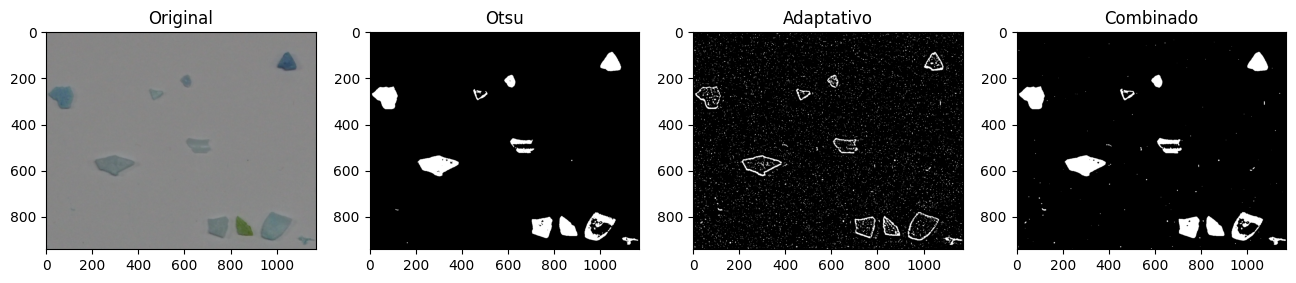

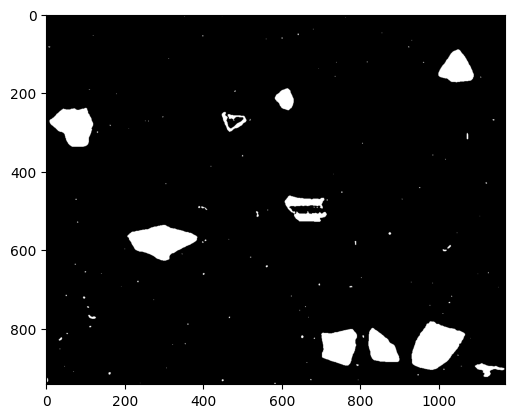

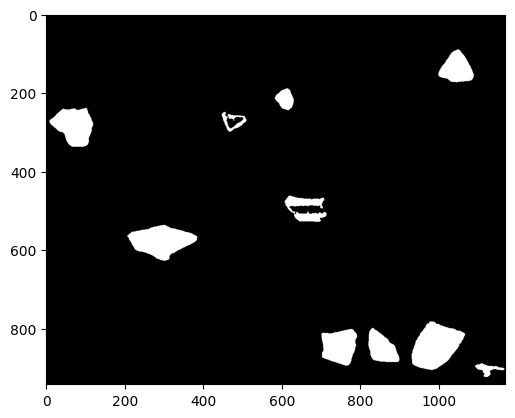

Se han encontrado los siguientes contornos: 10


In [64]:
image = cv2.imread('imgs/FRA.png')

max_height = 4000
if image.shape[0] > max_height:
    image_cropped = image[:max_height, :, :]  # [:altura, :ancho, :canales]
else:
    image_cropped = image

result = thresholds_and_image_manipulation(image_cropped)

pepe = np.zeros(result.shape)
pepe1 = np.zeros(result.shape)
contours, _ = cv2.findContours(result,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(pepe, contours, -1, 255, -1)
plt.imshow(pepe, cmap='gray')
plt.show()

contours = [x for x in contours if cv2.contourArea(x) > 335 and cv2.contourArea(x)]
cv2.drawContours(pepe1, contours, -1, color=255, thickness=-1)


plt.imshow(pepe1, cmap='gray')
plt.show()
print("Se han encontrado los siguientes contornos:", len(contours))





# Funciones: Extraen y retorna los contornos

In [7]:
def extract_contours_from_image(image):

    modified_image = thresholds_and_image_manipulation(image)
    contours, _ = cv2.findContours(modified_image,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    
    return contours


def extract_region_from_bounding_box(image, x_min, y_min, x_max, y_max):
    return image[y_min:y_max, x_min:x_max]



# Entrenamiento

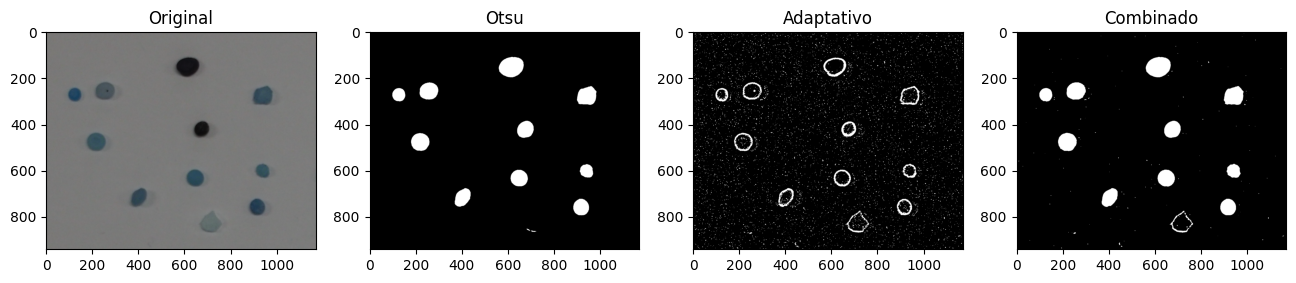

Contornos detectados de la imagen de pellet: 11
{'Area': 841.0, 'Perimeter': 400.61731135845184, 'Compacidad': 190.83737236631956, 'Circularity': 0.06584858331751471, 'Area_ratio': 0.10525657071339174, 'Aspect_ratio': 0.9042553191489362, 'E_ratio': 0.6378178721395239, 'D_ratio': np.float64(0.3206579380992794), 'Intensity': np.float64(101.93465346534653), 'Std': np.float64(6.597155637369495), 'test': np.float64(6.712252521654861), 'Solidity': 0.16868919867616086}
{'Area': 3772.5, 'Perimeter': 228.8944422006607, 'Compacidad': 13.888049216793004, 'Circularity': 0.9048333871948194, 'Area_ratio': 0.7813794531897266, 'Aspect_ratio': 0.9577464788732394, 'E_ratio': 0.9435016343422052, 'D_ratio': np.float64(0.9010010704510126), 'Intensity': np.float64(67.98011363636364), 'Std': np.float64(8.407669854589974), 'test': np.float64(61.51067648347964), 'Solidity': 0.9905474596297755}
{'Area': 3976.0, 'Perimeter': 245.62236440181732, 'Compacidad': 15.173628243043042, 'Circularity': 0.8281717736244611,

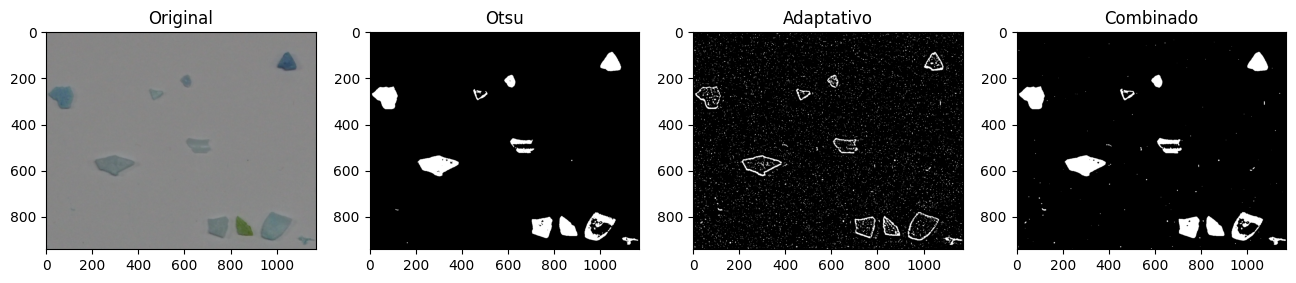

Contornos detectados de la imagen de fragmento: 9


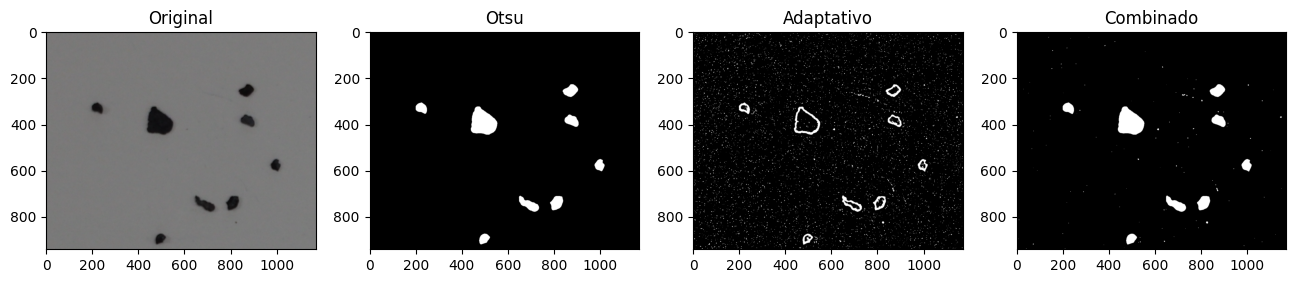

Contornos detectados de la imagen de alquitrán: 8
Muestras de entrenamiento: 28
Características: ['Area', 'Perimeter', 'Compacidad', 'Circularity', 'Area_ratio', 'Aspect_ratio', 'E_ratio', 'D_ratio', 'Intensity', 'Std', 'test', 'Solidity']
Distribución de clases: (array(['alquitrán', 'fragmento', 'pellet'], dtype='<U9'), array([ 8,  9, 11]))

Entrenando Random Forest...
fin del entrenamiento


In [67]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns


labels = {
    "pellet": (0,255,0),
    "fragmento": (255,0,0),
    "alquitrán": (0,0,255)
}

"""training_images = {
    "pellet": ["imgs/pellet-03-olympus-10-01-2020.JPG", "imgs/PEL.png"],
    "fragmento": ["imgs/fragment-03-olympus-10-01-2020.JPG", "imgs/FRA.png"],
    "alquitrán": ["imgs/tar-03-olympus-10-01-2020.JPG", "imgs/TAR.png"]
}"""

training_images = {
    "pellet": ["imgs/PEL.png"],
    "fragmento": ["imgs/FRA.png"],
    "alquitrán": ["imgs/TAR.png"]
}

"""training_images = {
    "pellet": ["imgs/pellet-03-olympus-10-01-2020.JPG"],
    "fragmento": ["imgs/fragment-03-olympus-10-01-2020.JPG"],
    "alquitrán": ["imgs/tar-03-olympus-10-01-2020.JPG"]
}"""


X, Y = [], []
feature_names = None

for label_name,images in training_images.items():

    for label_image_path in images:
        current_training_image = cv2.imread(label_image_path)

        if current_training_image is None:
            raise FileNotFoundError(f"No se enontró ninguna imagen en el directorio: {label_image_path}")
        
        current_contours = extract_contours_from_image(current_training_image)
        current_contours = [x for x in current_contours if cv2.contourArea(x) > 325 and cv2.contourArea(x) < 10000]
        print(f"Contornos detectados de la imagen de {label_name}: {len(current_contours)}")
        

        for contour in current_contours:
            current_features = geometric_features(contour, extract_contour_region(current_training_image, contour))
            
            if feature_names is None:
                feature_names = list(current_features.keys())

            if label_image_path == 'imgs/PEL.png':
                print(current_features)

            X.append(list(current_features.values()))
            Y.append(label_name)

X = np.array(X)
Y = np.array(Y)

print(f"Muestras de entrenamiento: {len(X)}")
print(f"Características: {feature_names}")
print(f"Distribución de clases: {np.unique(Y, return_counts=True)}")


scaler = StandardScaler() # x_scaled = (x - mean) / standard_deviation
X_train_scaled = scaler.fit_transform(X)

print("\nEntrenando Random Forest...")
clf = RandomForestClassifier(n_estimators=100,
                            random_state=42, 
                            max_depth=10,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            n_jobs=1)
clf.fit(X_train_scaled, Y)
print("fin del entrenamiento")


# Predicción en Test

## Función para obtener el centro de un contorno

In [10]:
def get_center(contour):
    x, y, w, h = cv2.boundingRect(contour)
    center_x = x + w // 2
    center_y = y + h // 2
    return (center_x, center_y)

## Árbol para encontrar las anotaciones que coinciden con un centro dado rápidamente

In [12]:
import csv
from rtree import index

# --- Cargar las anotaciones ---
annotations = []

with open('imgs/MPs_test_bbs.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        label = row['label']
        x_min = int(row['x_min'])
        y_min = int(row['y_min'])
        x_max = int(row['x_max'])
        y_max = int(row['y_max'])

        annotations.append({
            'label': label,
            'bbox': (x_min, y_min, x_max, y_max)
        })

# --- Crear índice espacial ---
idx = index.Index()

for i, ann in enumerate(annotations):
    x_min, y_min, x_max, y_max = ann['bbox']
    idx.insert(i, (x_min, y_min, x_max, y_max))

# --- Función para buscar el rectángulo que contiene un punto ---
def buscar_anotacion(cx, cy):
    # Buscar posibles rectángulos que contengan el punto
    posibles = list(idx.intersection((cx, cy, cx, cy)))

    for i in posibles:
        x_min, y_min, x_max, y_max = annotations[i]['bbox']
        if x_min <= cx <= x_max and y_min <= cy <= y_max:
            return annotations[i]  # Devuelve el rectángulo encontrado

    return None  # No se encontró ninguno

## Clasificación

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Muestras de test: 129


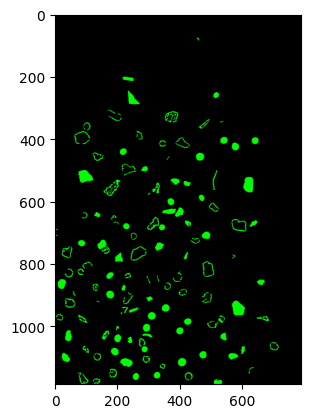

In [72]:
import csv

test_image_path = "imgs/MPs_test.jpg"
test_bbs_path = "imgs/MPs_test_bbs.csv"

label_mapping = {
    'PEL': 'pellet',
    'FRA': 'fragmento',
    'TAR': 'alquitrán'
}

x_test = []
y_true = []
y_true_raw = []
test_countours = []
bounding_boxes = []

test_image = cv2.imread(test_image_path)
if current_training_image is None:
    raise FileNotFoundError(f"No se enontró ninguna imagen en el directorio: {label_image_path}")

X, Y = [], []
feature_names = None
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
gaussian = cv2.GaussianBlur(gray, (5,5), 0)
adap_th = cv2.adaptiveThreshold(gaussian,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

current_contours, _ = cv2.findContours(
    adap_th,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

areas = np.array([cv2.contourArea(contour) for contour in current_contours])
lower_bound = max(0, np.percentile(areas, 75))
upper_bound = np.percentile(areas, 100)
current_contours = [x for x in current_contours if lower_bound <= cv2.contourArea(x) <= upper_bound]

image_contours = np.zeros(test_image.copy().shape)
cv2.drawContours(image_contours, current_contours, -1, (0, 255, 0), -1)
plt.imshow(image_contours, cmap='gray')

for contour in current_contours:
    current_features = geometric_features(contour, extract_contour_region(test_image, contour))
            
    if feature_names is None:
        feature_names = list(current_features.keys())

    cx, cy = get_center(contour)

    real_label = buscar_anotacion(cx, cy)

    if real_label is None: continue

    X.append(list(current_features.values()))
    y_true.append(label_mapping[real_label['label']])

X = np.array(X)
y_true = np.array(y_true)

print(f"Muestras de test: {len(X)}")

X = scaler.transform(X)
y_pred = clf.predict(X)

from collections import Counter

for t, p in zip(y_true, y_pred):
    pass


# Métricas de Evaluación:


MÉTRICAS:
Accuracy: 0.7829
Precision: 0.7842
Recall: 0.7829
F1-Score: 0.7598

              precision    recall  f1-score   support

   alquitrán       0.67      0.27      0.38        15
   fragmento       0.77      0.96      0.86        80
      pellet       0.87      0.59      0.70        34

    accuracy                           0.78       129
   macro avg       0.77      0.61      0.65       129
weighted avg       0.78      0.78      0.76       129


Matriz de confusión: 
[[ 4 10  1]
 [ 1 77  2]
 [ 1 13 20]]


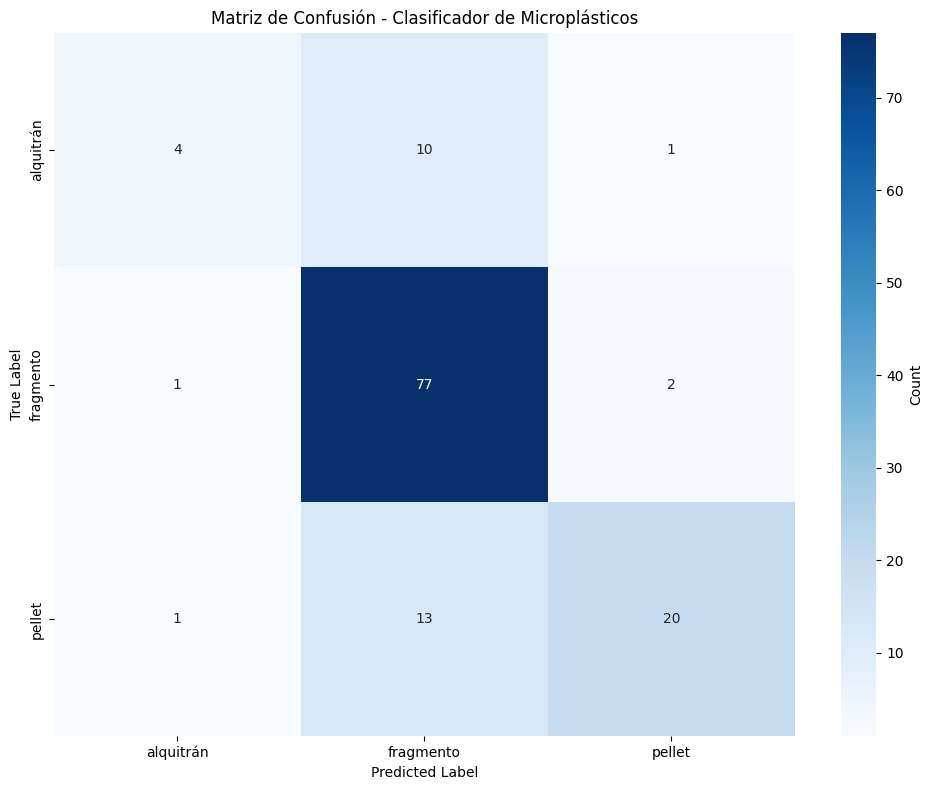

In [69]:
print("\nMÉTRICAS:")

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"\n{classification_report(y_true, y_pred, labels=clf.classes_)}")


c_matrix = confusion_matrix(y_true, y_pred, labels=clf.classes_)
print(f"\nMatriz de confusión: ")
print(c_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf.classes_, 
            yticklabels=clf.classes_,
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Matriz de Confusión - Clasificador de Microplásticos')
plt.tight_layout()
plt.show()

# Dibujar identificaciones:

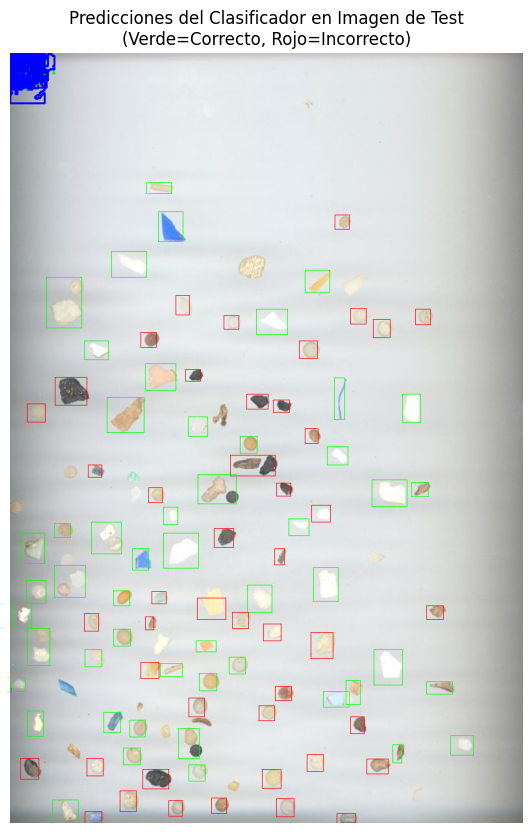

In [ ]:
image_viz = test_image
colors = {class_name: labels[class_name] for class_name in clf.classes_}

for contour, pred in zip(test_countours, y_pred):
    color = colors[pred]
    cv2.drawContours(image_viz, [contour], 0, color, 2)

for (x_min, y_min, x_max, y_max), true_label, pred_label in zip(bounding_boxes, y_true, y_pred):
    color = (0, 255, 0) if true_label == pred_label else (0, 0, 255)
    cv2.rectangle(image_viz, (x_min, y_min), (x_max, y_max), color, 1)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image_viz, cv2.COLOR_BGR2RGB))
plt.title('Predicciones del Clasificador en Imagen de Test\n(Verde=Correcto, Rojo=Incorrecto)')
plt.axis('off')
plt.show()